## Plotting percentiles as proxies for emissions

In the case that we don't have (or don't want to bother to calculate) regional emissions for a given species, it can sometimes be helpful (Rigby et al.(2019), Park et al. (2021) are some examples for CFC-11) to look at the number and magnitudes of pollution events. In particular, a box-and-whisker plot can show trends in the size of pollution events, especially at the 75th/90th percentile level, and give a sense of what emissions are doing in this region. While not as rigorous as full Bayesian inverse modelling, this can still be a useful exercise. In this notebook, I will give an example of how to do this using Python. 

In [46]:
# imports

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

Let's look at the CFC-11 data record from Gosan, South Korea. This can give an indication of emissions from eastern China, the Korean Peninisula and Japan. 

In [47]:
# open data

ds = xr.open_dataset('../data/AGAGE-GSN_cfc-11-17m.nc')
ds

<xarray.Dataset>
Dimensions:              (time: 23796)
Coordinates:
  * time                 (time) datetime64[ns] 2007-11-14T20:36:00 ... 2019-1...
Data variables:
    cfc11                (time) float32 ...
    cfc11_repeatability  (time) float64 ...
Attributes: (12/31)
    Conventions:                  CF-1.8
    calibration_scale:            SIO-05
    comment:                      Medusa measurements. Output from GCWerks. S...
    conditions_of_use:            Ensure that you contact the data owner at t...
    data_acknowledgements:        Please thank the listed contacts (who are n...
    data_availability_statement:  These data are made available to the scient...
    ...                           ...
    sampling_period_unit:         s
    site:                         gsn
    source:                       In situ measurements of air
    species:                      cfc11
    station_long_name:            Gosan, Jeju Island
    version:                      20240719

Quickly look at the data:

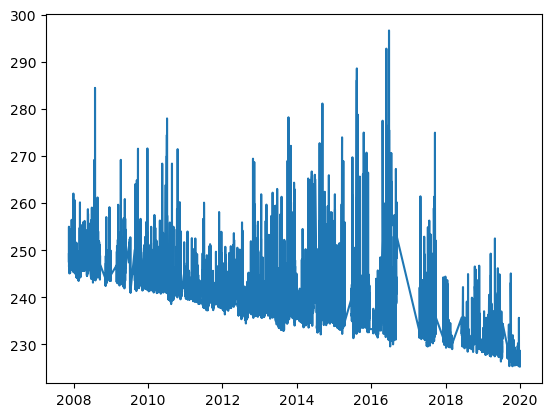

In [17]:
plt.plot(ds.time, ds.cfc11)

Clearly, the mean/median values will be skewed by the long-term decreasing background concentration of CFC-11 in the atmosphere, due to the (mostly) successful Montreal Protocol. We would really like to look at the enhancements/pollution events above this baseline, if possible. There are many ways to calculate a baseline, but a nice 'rough-and-ready' way to do this is to just take, say, the 10th percentile of all measurements in a given year. We can check that this looks OK:

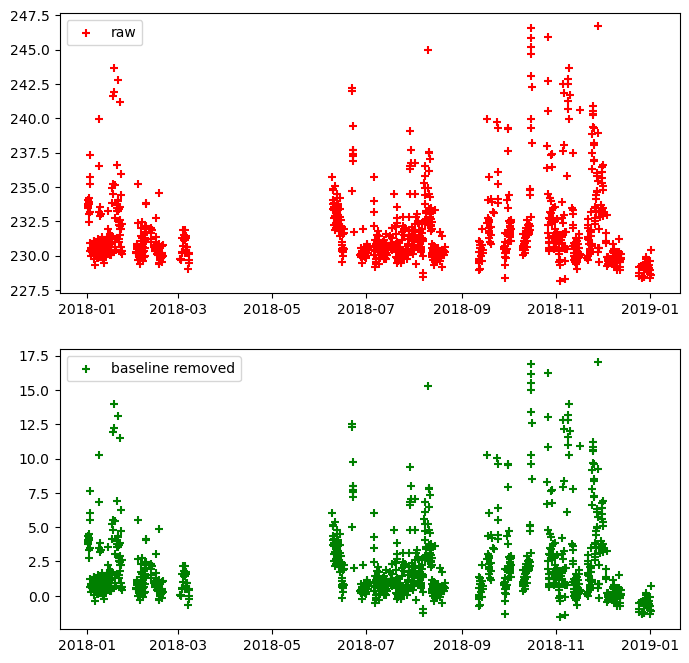

In [52]:
# select just one year
data_2018 = ds.sel(time=slice('2018-01-01', '2019-01-01'))

# take the 10th percentile and subtract
baseline = np.nanpercentile(data_2018['cfc11'].values, 10)
data_2018['cfc11_enhancement'] = data_2018['cfc11'] - baseline

# plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8))
ax1.scatter(data_2018.time, data_2018['cfc11'], label = 'raw', marker='+', color='red')
ax2.scatter(data_2018.time, data_2018['cfc11_enhancement'], label = 'baseline removed', marker='+', color='green')
ax1.legend()
ax2.legend()

Yes this produces some negative values for enhancement, but overall it seems to have done the job. Let's apply to the whole dataset and produce a box plot

The commented out line produces a line that runs through the 75th percentiles. This could be a way of scaling emissions for multiple years...

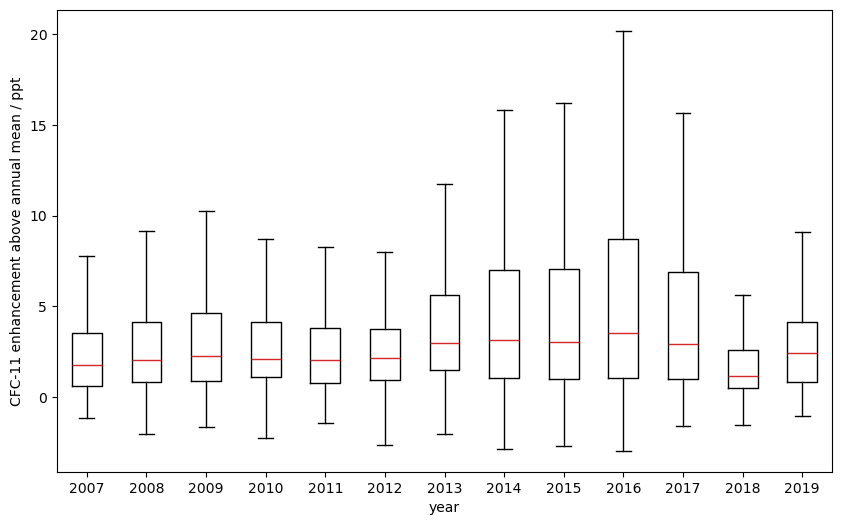

In [53]:
to_plot = {}
upper_quartiles = [] # also record the values of the upper quartiles - this could be useful for scaling emissions. Of course, we don't have to use the 75th percentile...

# iterate over a ds.groupby object, which returns (in this case) the year and the associated Dataset. 
for year, data in ds.groupby(ds.time.dt.year):
    baseline = np.nanpercentile(data.cfc11.values, 10)
    data['cfc11_enhancement'] = data['cfc11'] -  baseline
    to_plot[year] = data['cfc11_enhancement']
    upper_q = np.nanpercentile(data['cfc11_enhancement'].values, 75)
    upper_quartiles.append(upper_q)

fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(to_plot.values(), labels=to_plot.keys(), sym='', medianprops={'color':'tab:red'}) # I've chosen to not plot the 'fliers' (outside 1.5 IQR of Q3) - this is just a stylistic choice. 
# ax.plot(range(1,len(upper_quartiles)+1), upper_quartiles, linestyle='--', color='tab:blue')
ax.set_xlabel('year')
ax.set_ylabel('CFC-11 enhancement above annual mean / ppt')
fig.show()